# Setup Package

In [44]:
import torch as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt, seaborn as sns
import missingno as msno

# Data Visualizaton

## ETTm2

In [6]:
df_ettm2=pd.read_csv("Data/ETTm2.csv")

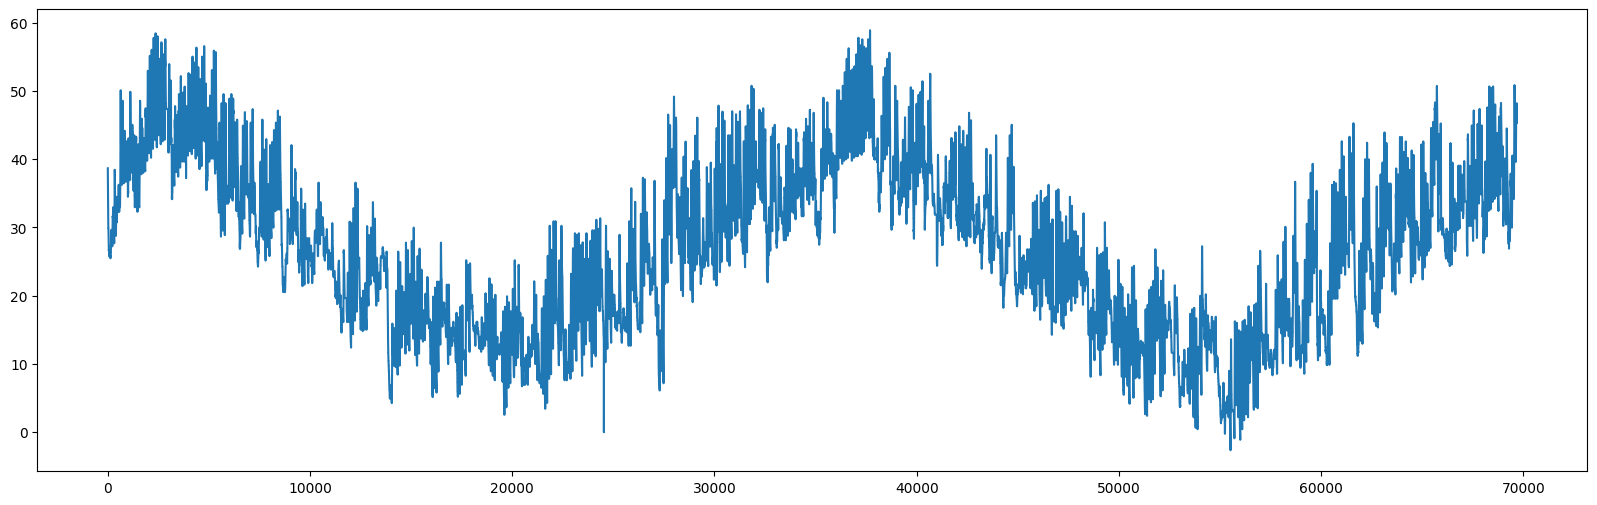

In [12]:
plt.figure(figsize=(20,6))
plt.plot(df_ettm2["OT"].to_numpy())

## Turbine Dataset

In [45]:
df_turbine=pd.read_csv("Data/Turbine_Data.csv")

### Cetak Missing Value

<Axes: >

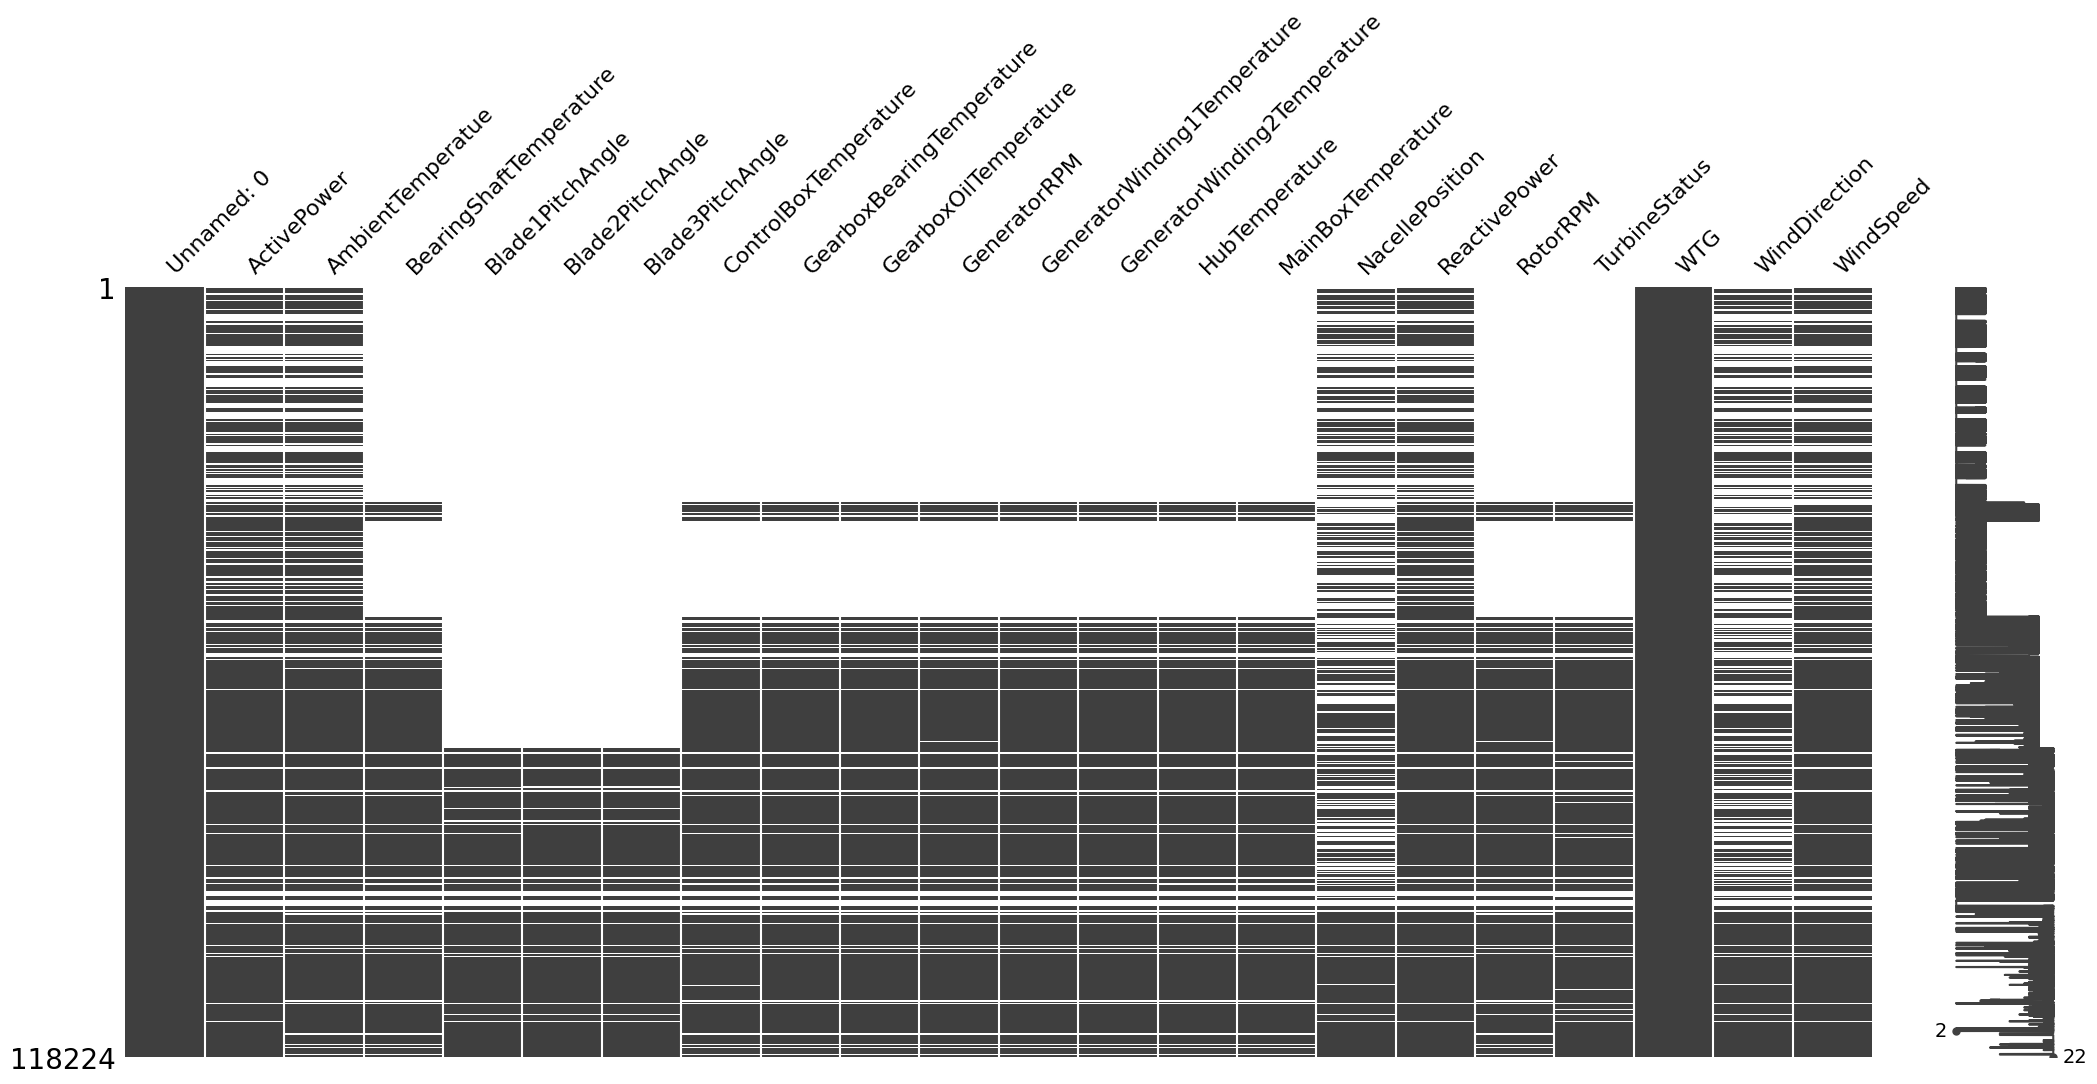

In [46]:
#the dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our LSTM model will not converge or we may end up feeding it with garbage data.
#the rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete. We will strive to use this part for training and testing.
msno.matrix(df_turbine)

In [55]:
df_turbine.iloc[:, 2::].corr(numeric_only = True)

,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
AmbientTemperatue,1.000000,0.246505,0.085461,0.090904,0.090904,NaN,0.017216,0.162511,-0.130123,0.077859,0.078736,0.589729,0.836539,-0.037498,-0.020313,-0.129290,-0.005511,-0.037498,-0.095308
BearingShaftTemperature,0.246505,1.000000,-0.475557,-0.466856,-0.466856,NaN,0.883344,0.772887,0.640947,0.765115,0.763926,0.809116,0.542104,0.183929,0.594546,0.640584,-0.000990,0.183929,0.596201
Blade1PitchAngle,0.085461,-0.475557,1.000000,0.997774,0.997774,NaN,-0.599178,-0.557949,-0.757056,-0.376102,-0.372369,-0.198583,0.194911,-0.058300,-0.381478,-0.757147,-0.000534,-0.058300,-0.403092
Blade2PitchAngle,0.090904,-0.466856,0.997774,1.000000,1.000000,NaN,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.000636,-0.057624,-0.402786
Blade3PitchAngle,0.090904,-0.466856,0.997774,1.000000,1.000000,NaN,-0.592103,-0.549792,-0.754325,-0.371057,-0.367451,-0.190296,0.190562,-0.057624,-0.379541,-0.754539,-0.000636,-0.057624,-0.402786
ControlBoxTemperature,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GearboxBearingTemperature,0.017216,0.883344,-0.599178,-0.592103,-0.592103,NaN,1.000000,0.906020,0.850209,0.853024,0.851923,0.596065,0.307694,0.214486,0.751875,0.850795,-0.002314,0.214486,0.800433
GearboxOilTemperature,0.162511,0.772887,-0.557949,-0.549792,-0.549792,NaN,0.906020,1.000000,0.806972,0.899693,0.898335,0.506648,0.190350,0.277619,0.770088,0.807776,-0.004536,0.277619,0.793140
GeneratorRPM,-0.130123,0.640947,-0.757056,-0.754325,-0.754325,NaN,0.850209,0.806972,1.000000,0.796434,0.795223,0.303804,-0.052185,0.176964,0.768065,0.999723,0.001133,0.176964,0.854787
GeneratorWinding1Temperature,0.077859,0.765115,-0.376102,-0.371057,-0.371057,NaN,0.853024,0.899693,0.796434,1.000000,0.999959,0.481905,0.215955,0.298452,0.838461,0.797077,-0.000651,0.298452,0.894777


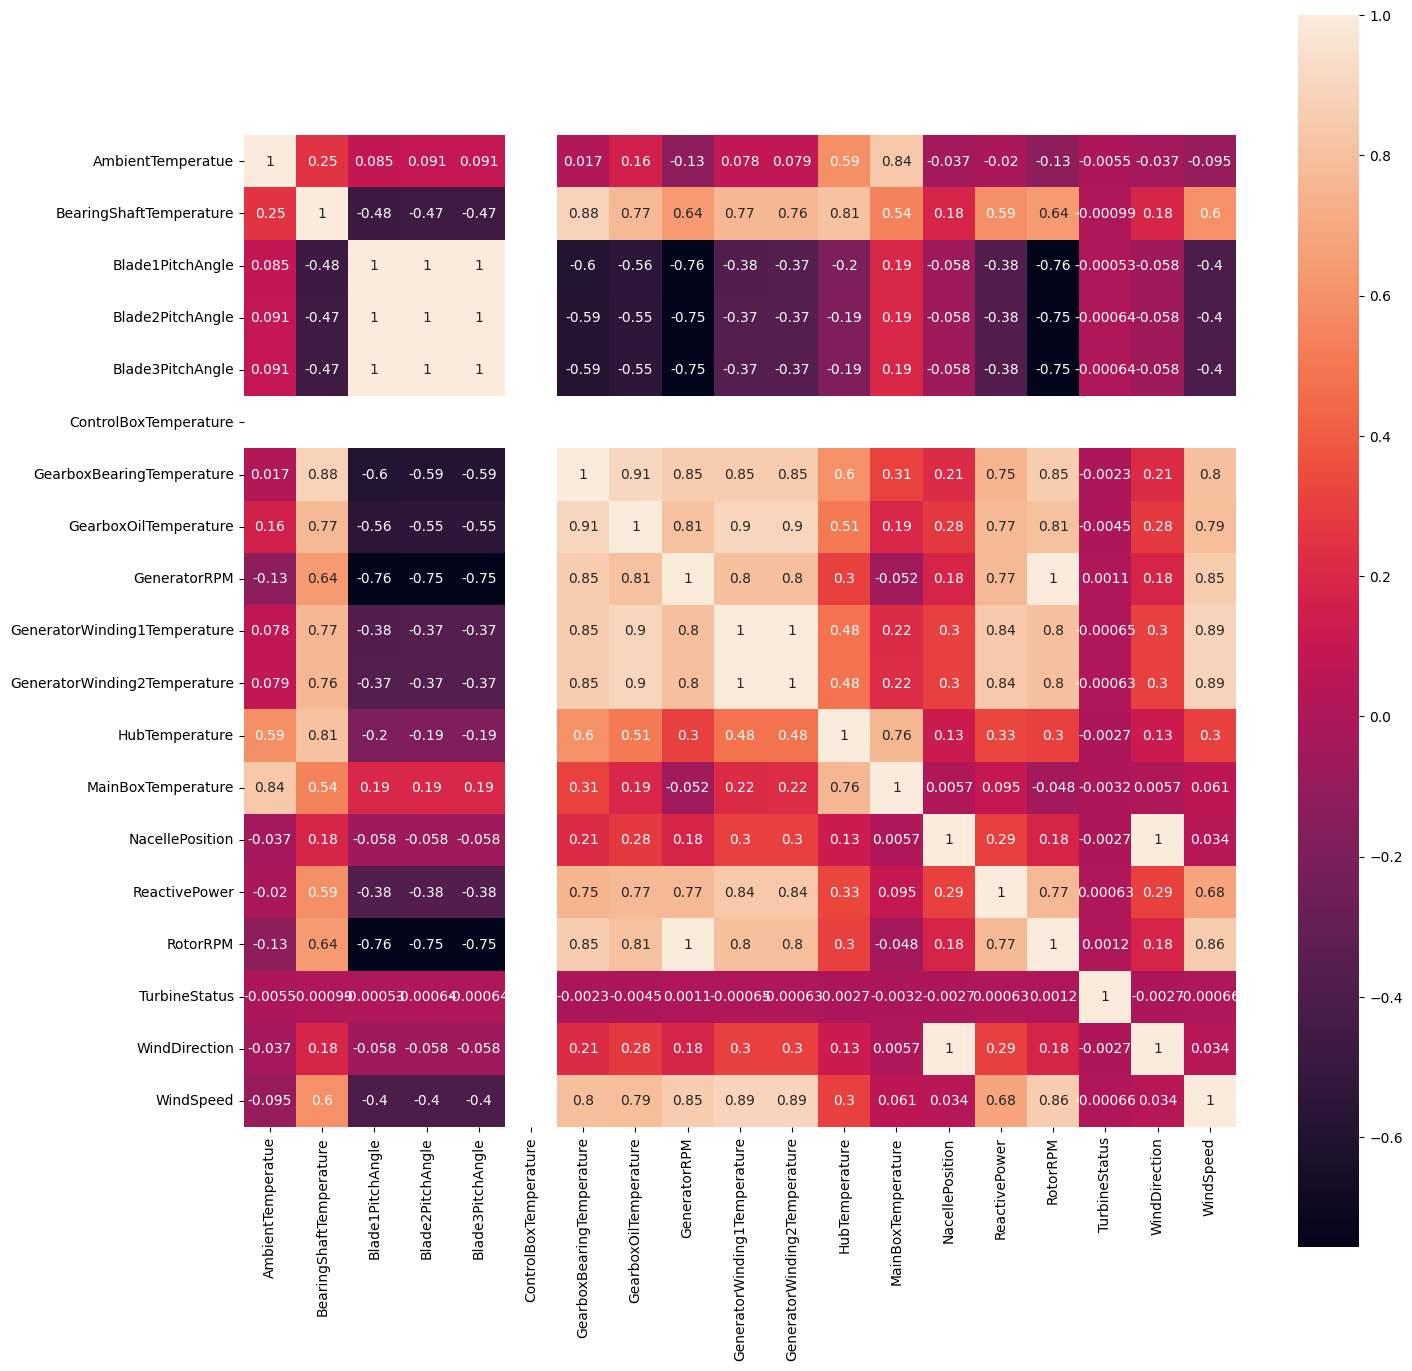

In [56]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_turbine.iloc[:, 1::].corr(numeric_only = True), annot=True, square=True)
plt.show()

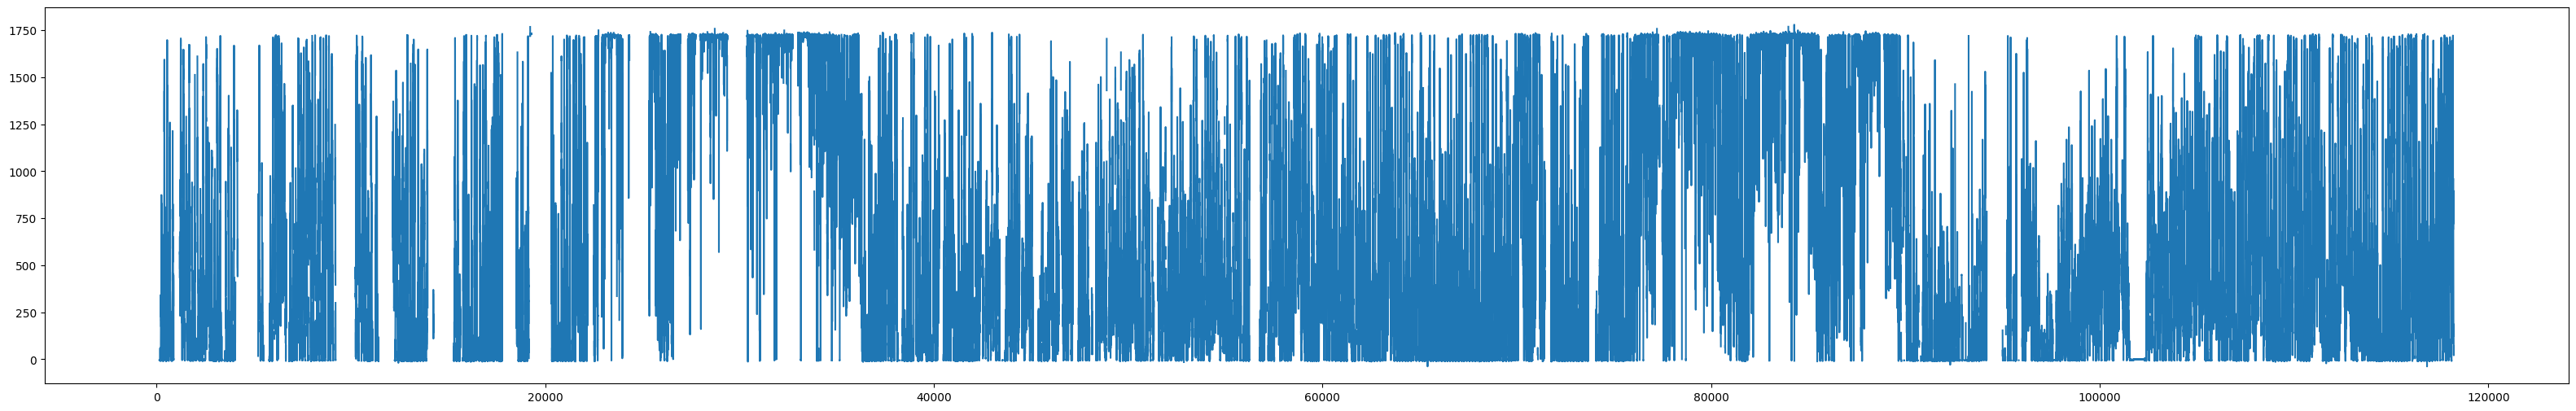

In [17]:
plt.figure(figsize=(40,6))
plt.plot(df_turbine["ActivePower"].to_numpy())

## M4 Dataset

In [35]:
df_m4=pd.read_csv("Data/m4/Monthly-train.csv")

In [38]:
df_m4.shape

(48000, 2795)

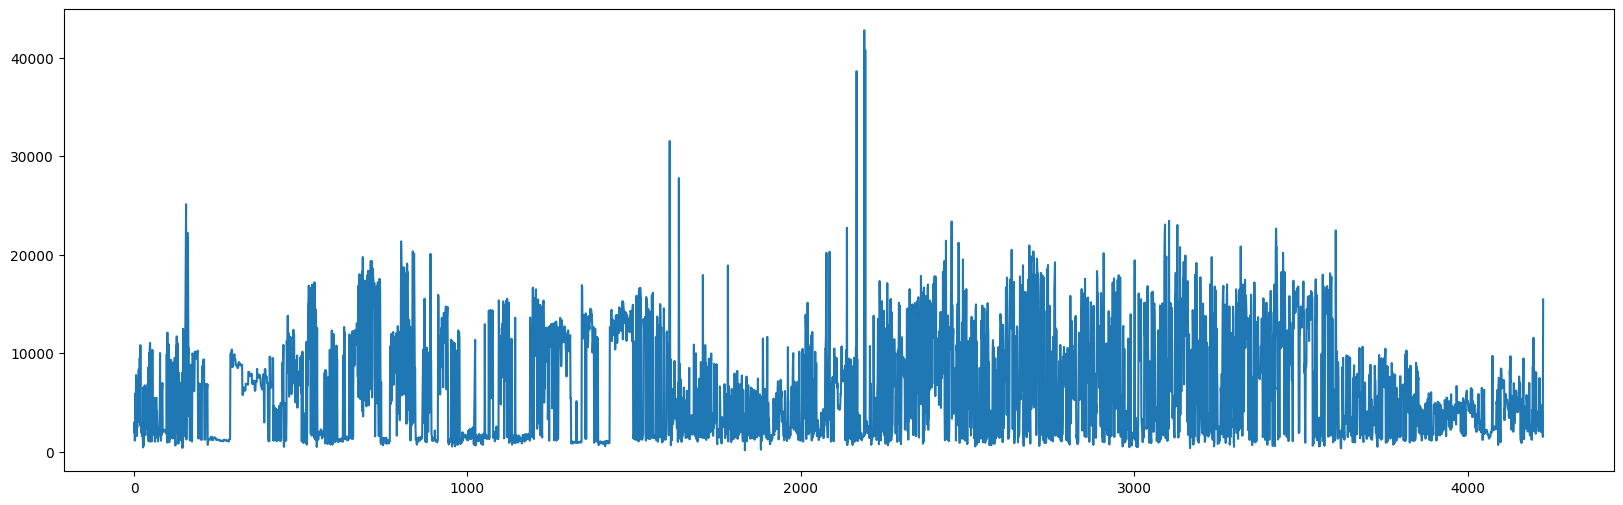

In [30]:
plt.figure(figsize=(20,6))
plt.plot(df_m4["V3"].to_numpy())

# Modelling

In [39]:
import torch as t

In [41]:
t.__version__

'2.0.1+cu118'